<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_06%5DMyFirstKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-06]나의 첫 번째 캐글 경진대회


## 0.시작하기전,,

> 캐글 초보인 여러명의 커널을 필사하여 완성 하였습니다.
[참고1](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)
[참고2](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)

[캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

RMSE
이번 대회의 평가 방식은 Root Mean Squared Error 입니다.
$${\sqrt{ {1 \over N} \sum{(yt - y{pr})}^2}} $$

In [1]:
!pip list | grep xgboost
!pip list | grep lightgbm
!pip list | grep missingno
!pip list | grep scikit-learn

xgboost                       0.90
lightgbm                      2.2.3
missingno                     0.5.0
scikit-learn                  0.22.2.post1


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/kaggle-kakr-housing-data.zip

--2021-08-09 12:41:39--  https://d3s0tskafalll9.cloudfront.net/media/documents/kaggle-kakr-housing-data.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 13.32.196.69, 13.32.196.231, 13.32.196.140, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|13.32.196.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 693719 (677K) [application/zip]
Saving to: ‘kaggle-kakr-housing-data.zip’

kaggle-kakr-housing 100%[===================>] 677.46K  --.-KB/s    in 0.009s  

2021-08-09 12:41:39 (71.1 MB/s) - ‘kaggle-kakr-housing-data.zip’ saved [693719/693719]



In [4]:
!unzip -qq '/content/kaggle-kakr-housing-data.zip'

In [5]:
ls /content/data

sample_submission.csv*  test.csv*  train.csv*


## 1.데이터 및 라이브러리 준비하기

###1.1필요한 라이브러리 import

In [98]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import norm #Analysis 
from scipy import stats #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings 
warnings.filterwarnings('ignore')

###1.2 데이터 불러오기

In [99]:
data_dir = '/content/data'

train_data_path = join(data_dir, 'train.csv')   
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/content/data/train.csv
/content/data/test.csv


In [100]:
df_train = pd.read_csv(train_data_path)
df_test= pd.read_csv(sub_data_path)
print('train data dim : {}'.format(df_train.shape))
print('sub data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


## 2.데이터 탐색 (EDA : Exploratory Data Analysis)

### 2.1 변수 설명

- ID : 집을 구분하는 번호  
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : Has been viewed
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [9]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

### 2.2 변수 시각화

#### 2.2.1 목적변수 (y = price)

In [101]:
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

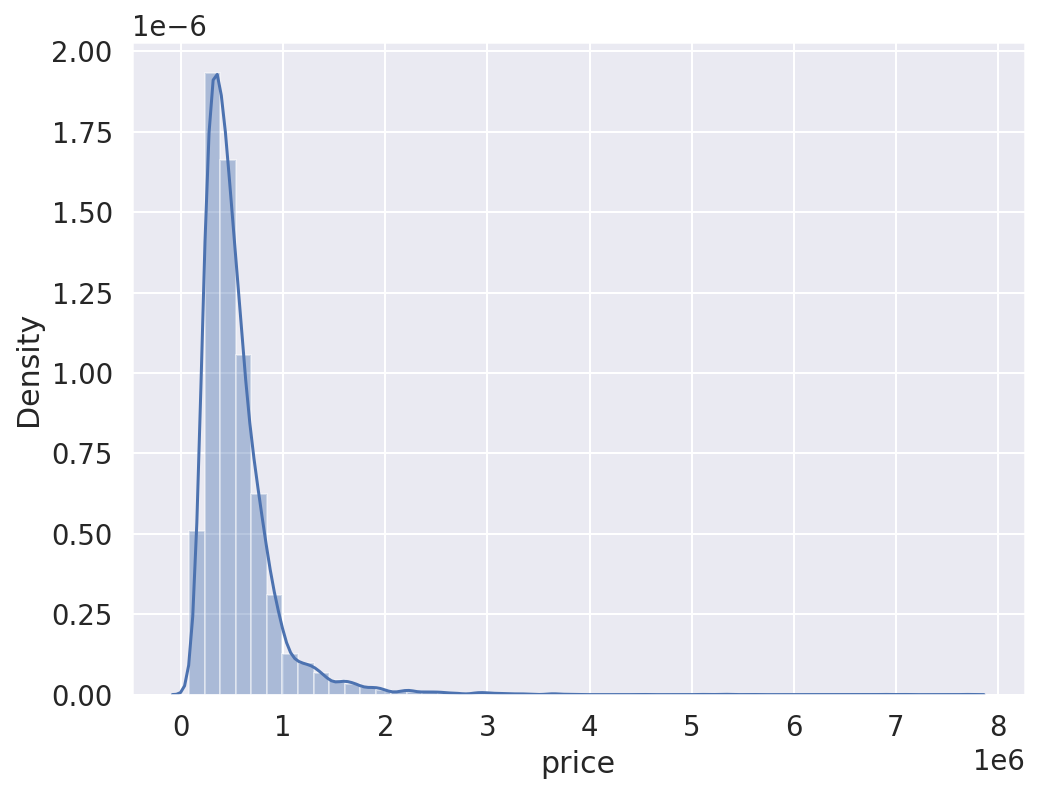

In [102]:
# histogram
#아래와 같이 써도 된다.
#sns.kdeplot(data['price'])
#plt.show()
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])


`price`의 경우 min과 max의 차이가 크고, std가 굉장히 큰편입니다. 위의 그림을 보면 왼쪽으로 분포가 굉장히 치우친 것을 알 수 있습니다. 저희는 **회귀 모델**을 이용할 것이기 때문에 **Nomalize**를 통해 price 의 분포가 **정규 분포**를 가지도록 만들어 주겠습니다.

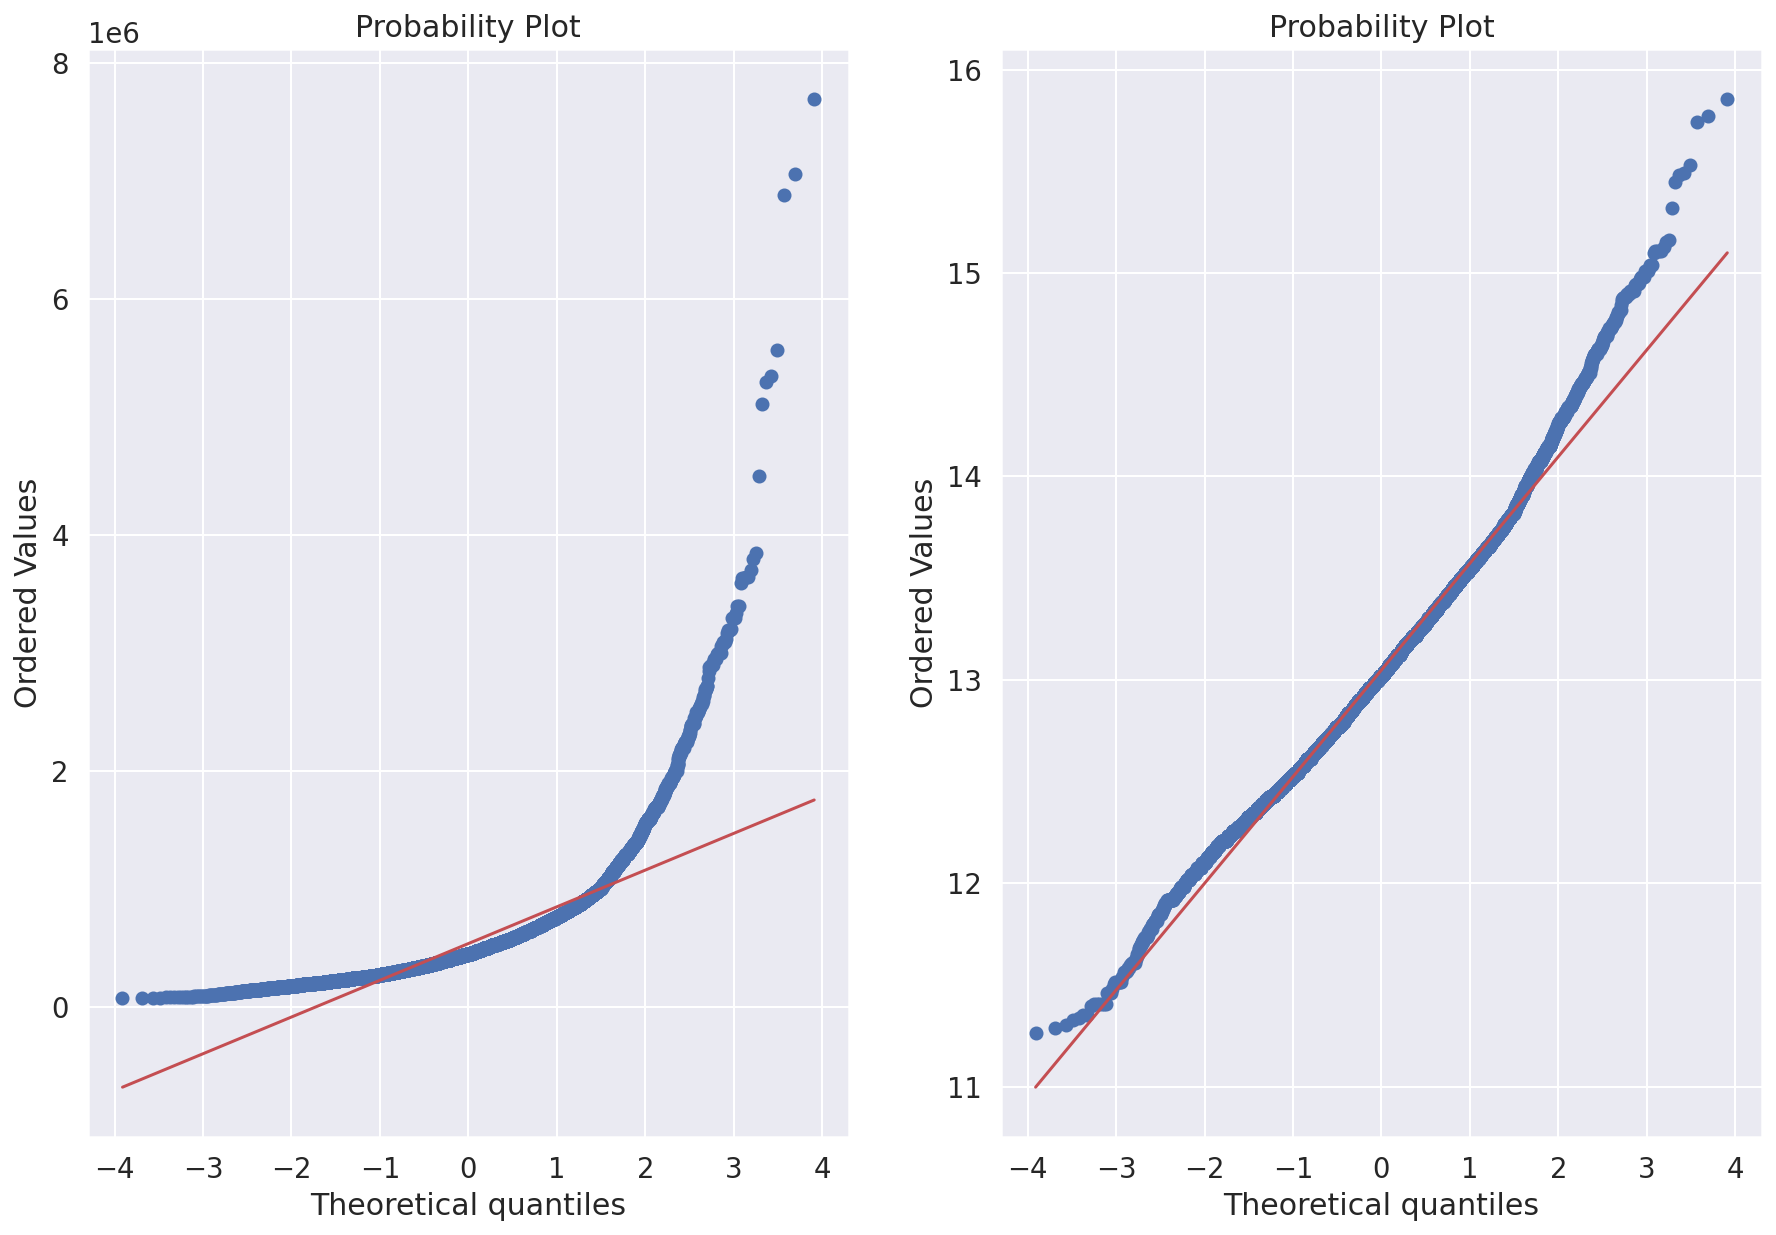

In [103]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)

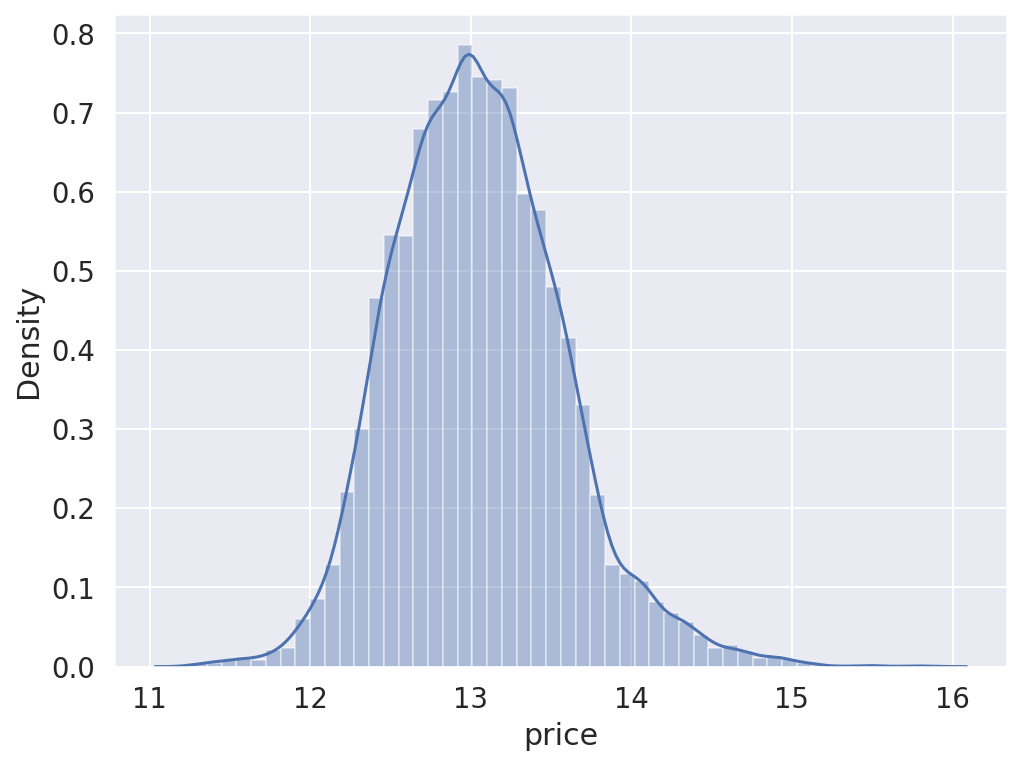

In [104]:
df_train['price'] = np.log1p(df_train['price'])     #log를 이용하여 nomalize
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

log를 취해주면 확실히 정규화된 모습을 볼 수 있습니다.  
이렇게 데이터를 전처리 해주는 것이 모델의 성능을 좌우 하기 때문에 중요합니다.


#### 2.2.2 반응변수 (x)

이제 목적변수(price)와 반응변수의 상관관계를 봅시다!
- 피어슨 상관관계 (Pearson) : 연속형 변수에 사용
- 스피어만 상관관계 (Spearman) : 범주형 변수도 포함되었을 경우에 사용
  
저희는 범주형 변수(ex.waterfront)도 포함 되어있기 때문에 스피어만 상관관계를 이용합니다.  

모든 변수를 다 보는 것이 아니라 상관도가 높은 상위 10개의 값만 보도록 하겠습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


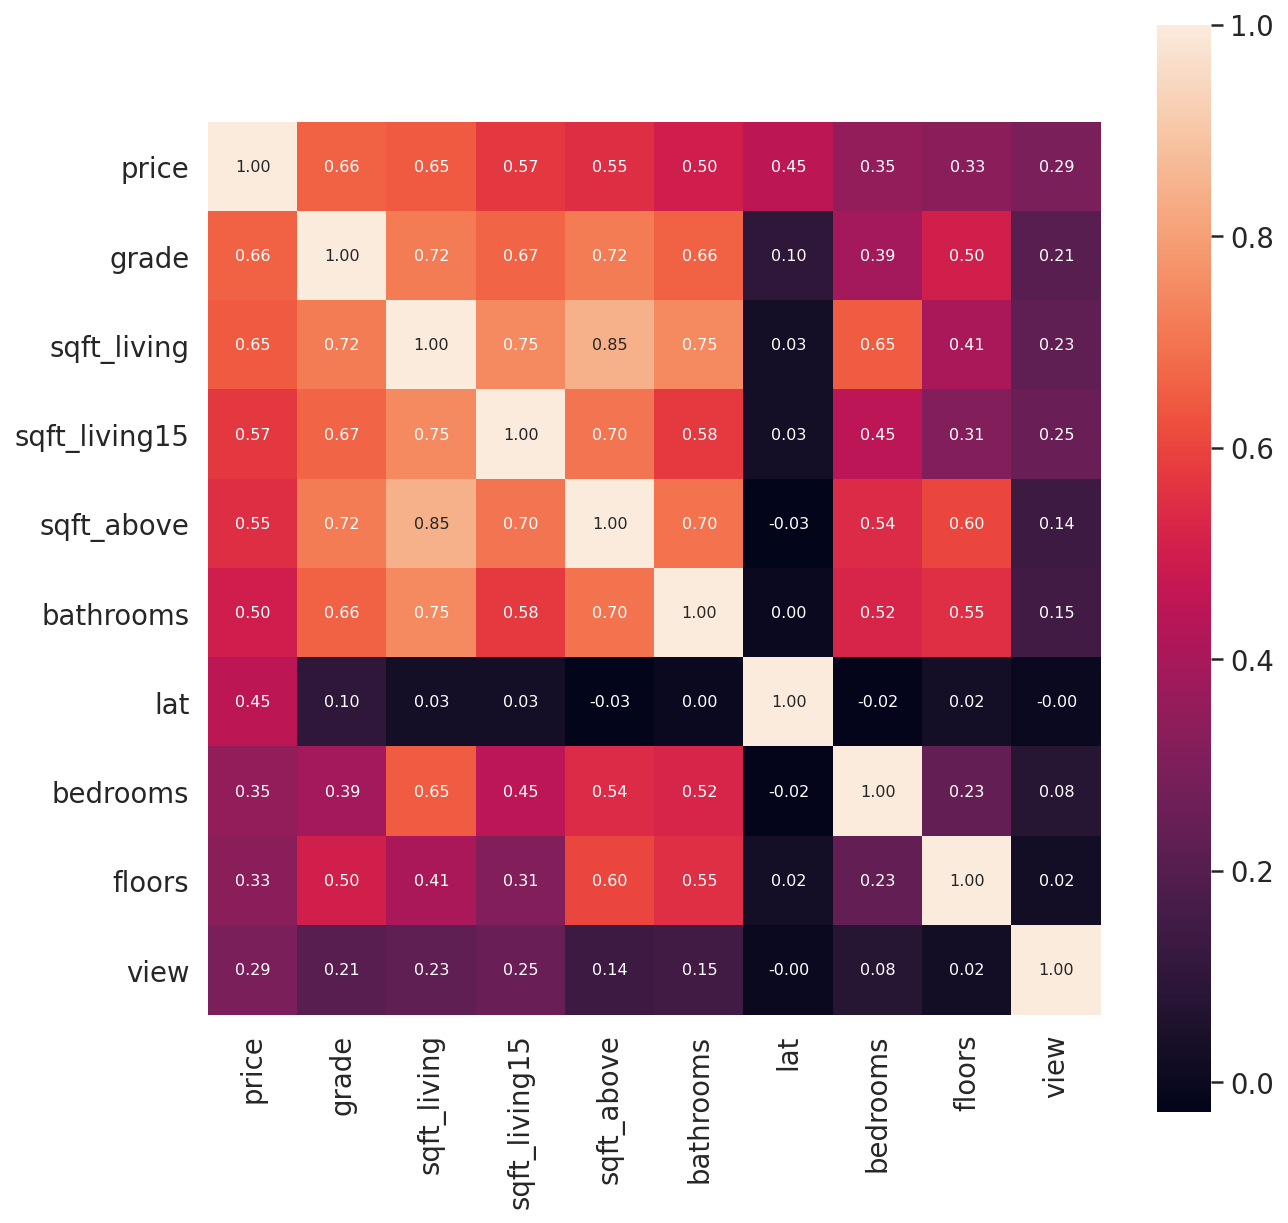

In [105]:
import scipy as sp

cor_abs = abs(df_train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(df_train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

#### 2.2.3 결측치 유무 확인

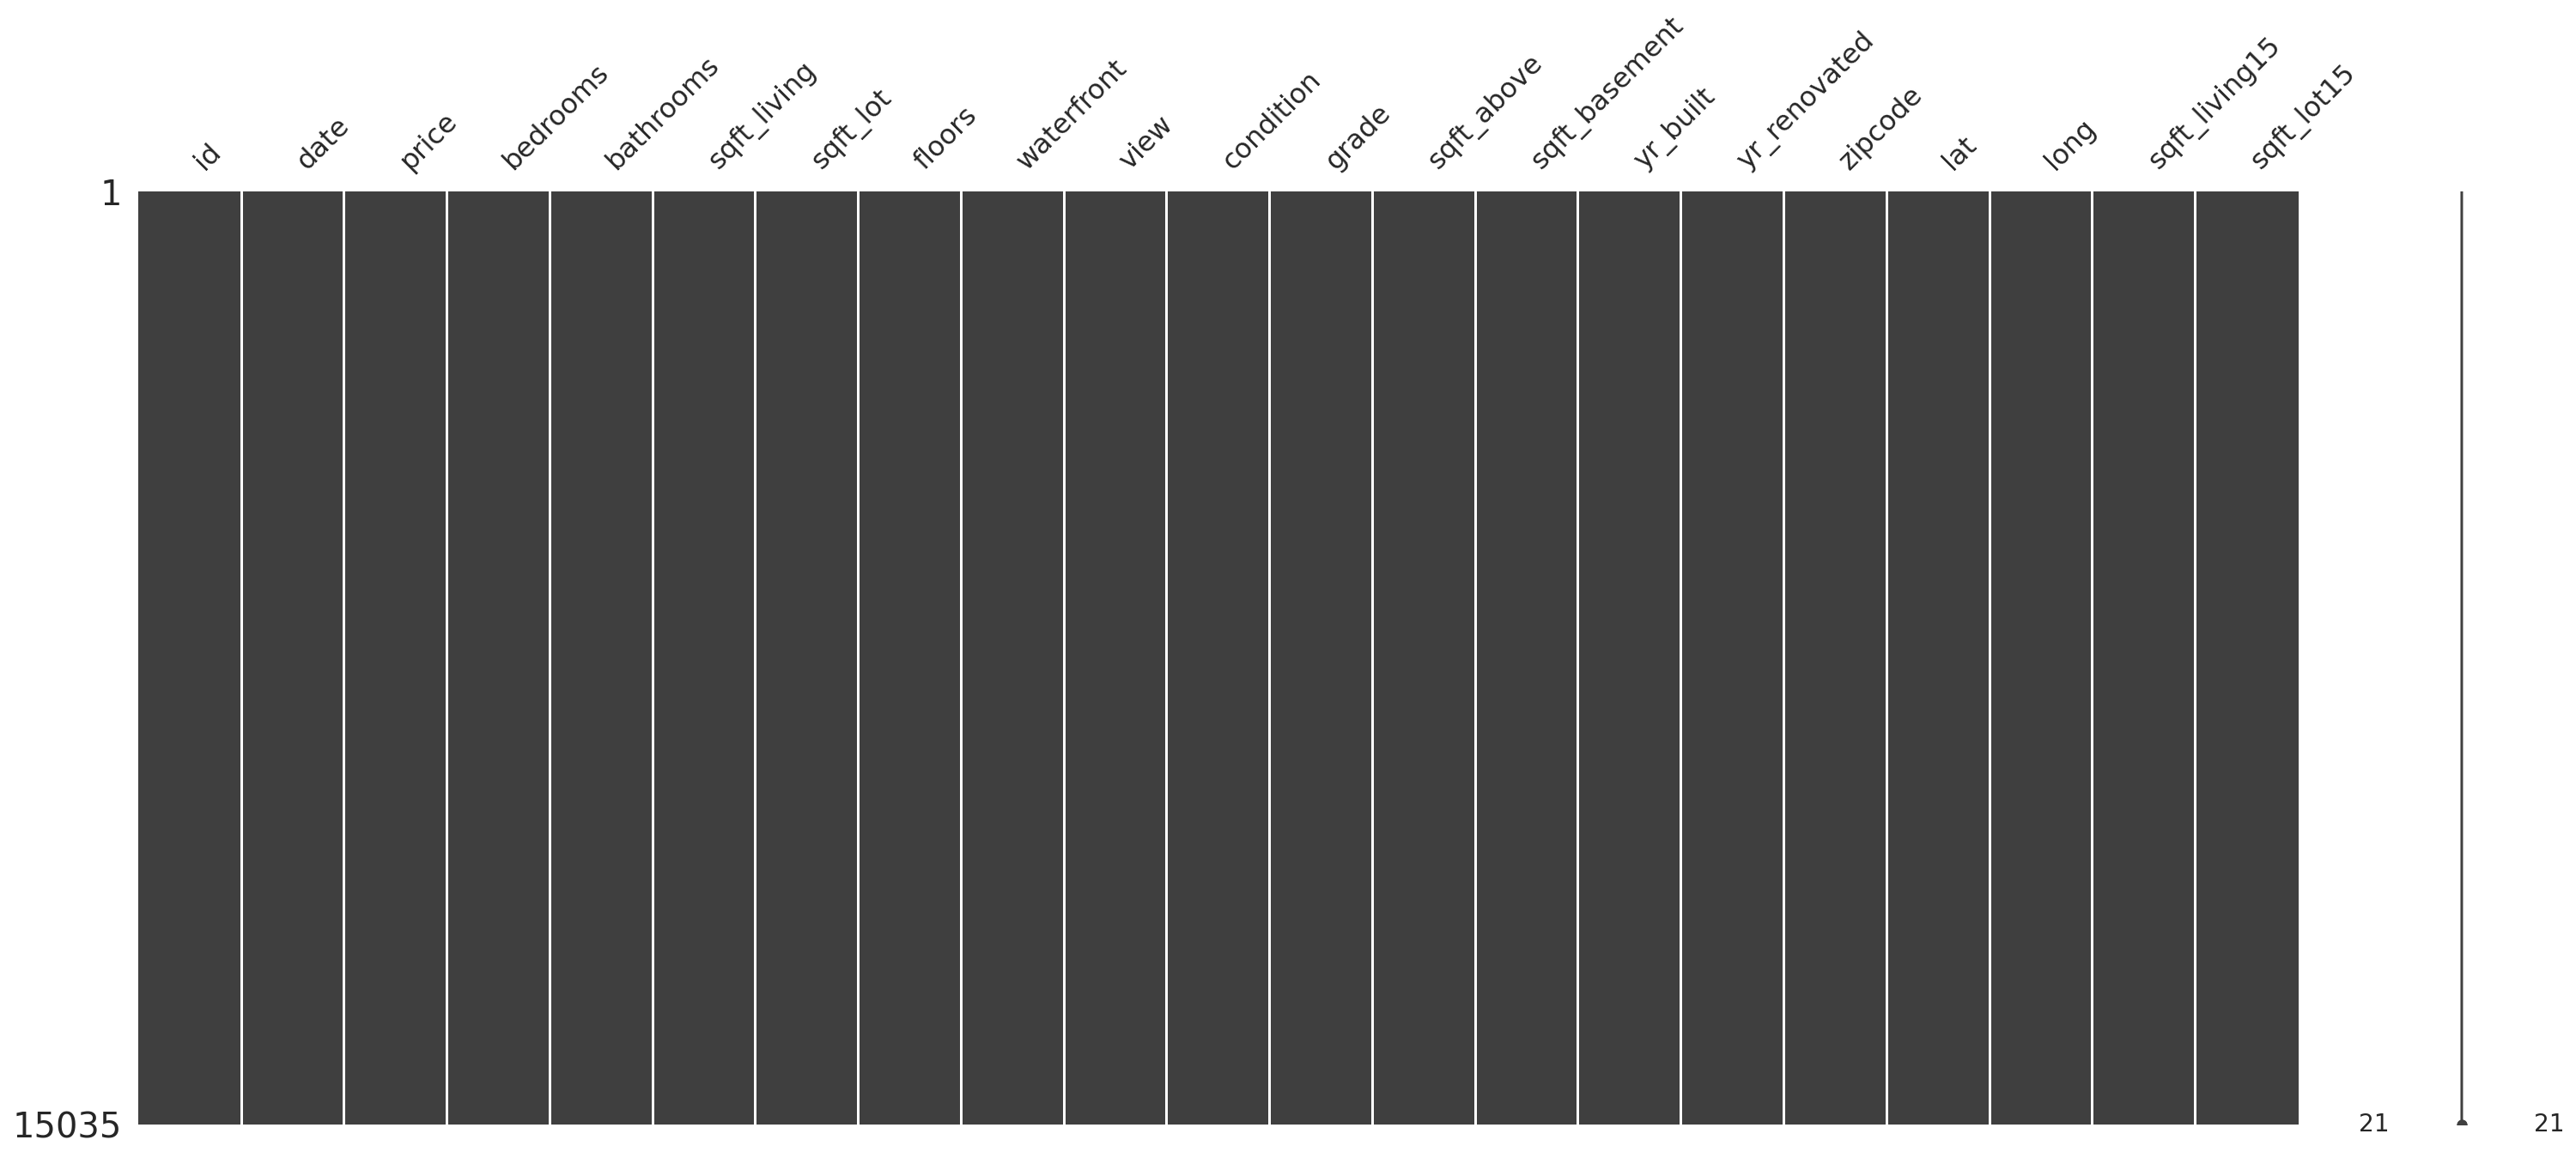

In [106]:
msno.matrix(df_train)

위 그림은 `DataFrame`을 매트릭스 모양 그대로 시각화 한 것입니다. 만약 특정 값이 NaN(결측치)가 있다면 해당 부분이 하얗게 나옵니다.  
이번 데이터는 매트릭스가 전부 까만걸 보니 결측치가 없군요!!

아래처럼 직접 결측치의 개수를 출력해서 확인할 수도 있습니다.

In [107]:
for c in df_train.columns:
    print('{} : {}'.format(c, len(df_train.loc[pd.isnull(df_train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### 2.2.4 유니크한 갯수

## 3 데이터 전처리

### 3.1 이상치 제거 

#### 3.1.1 sqft_living

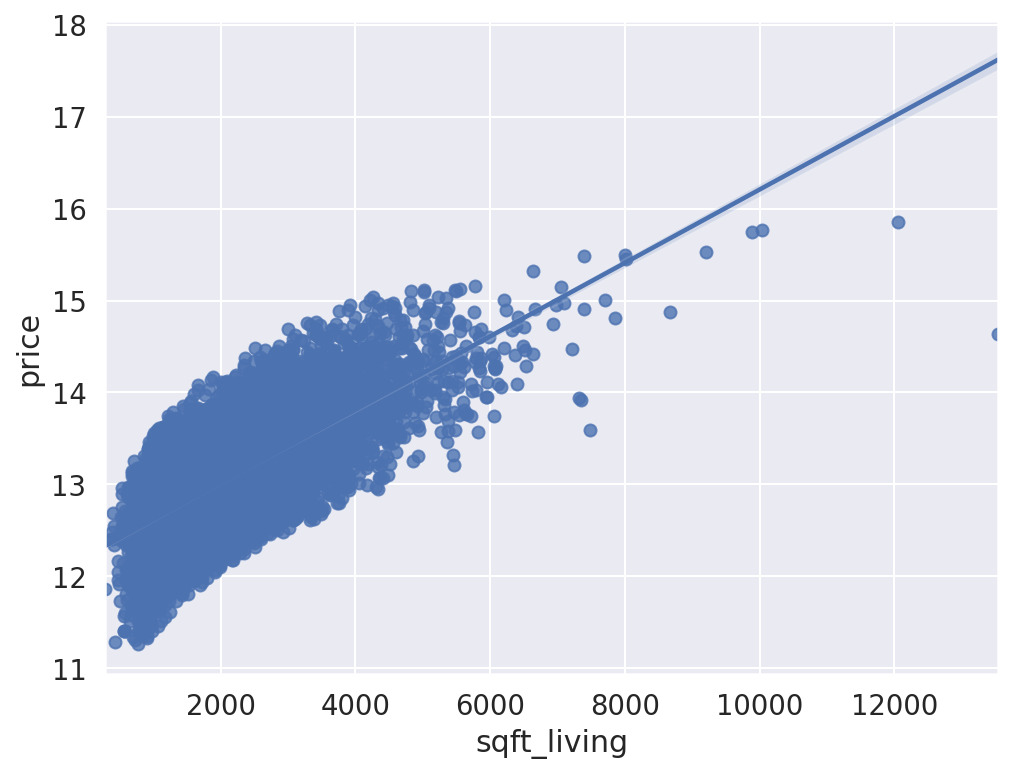

In [108]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [109]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [110]:
df_train = df_train.loc[df_train['id']!=8990]

#### 3.1.2 grade

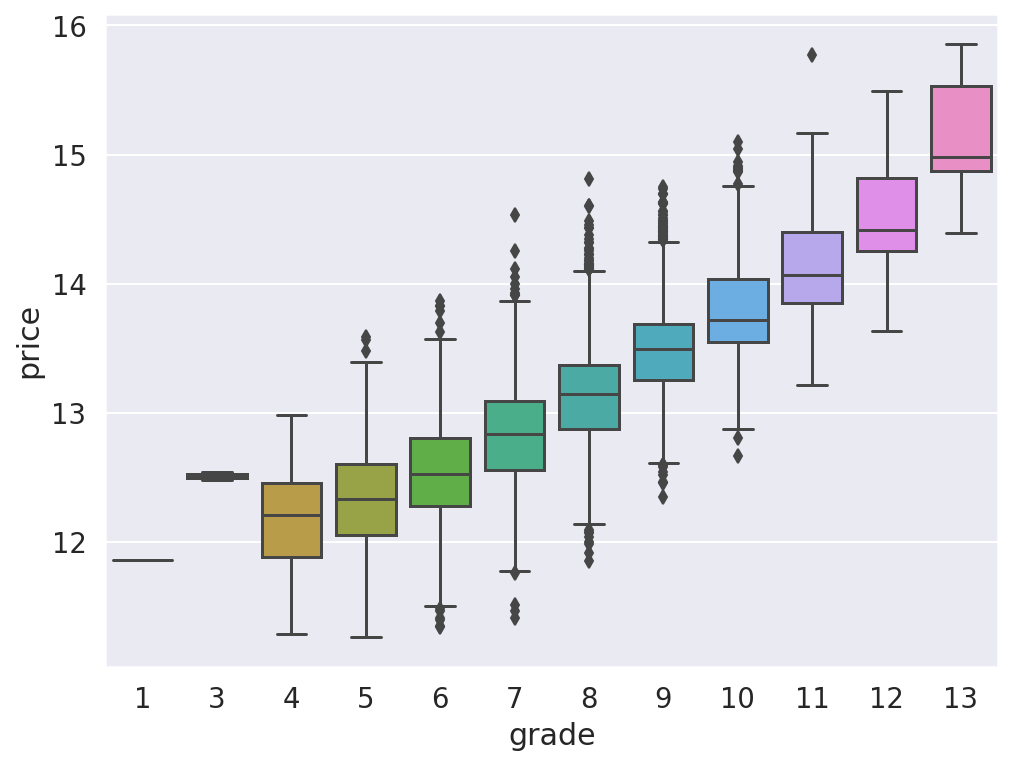

In [111]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [112]:
df_train.loc[(df_train['price']>12) & (df_train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [113]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [114]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


In [115]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

#### 3.1.3 beadrooms

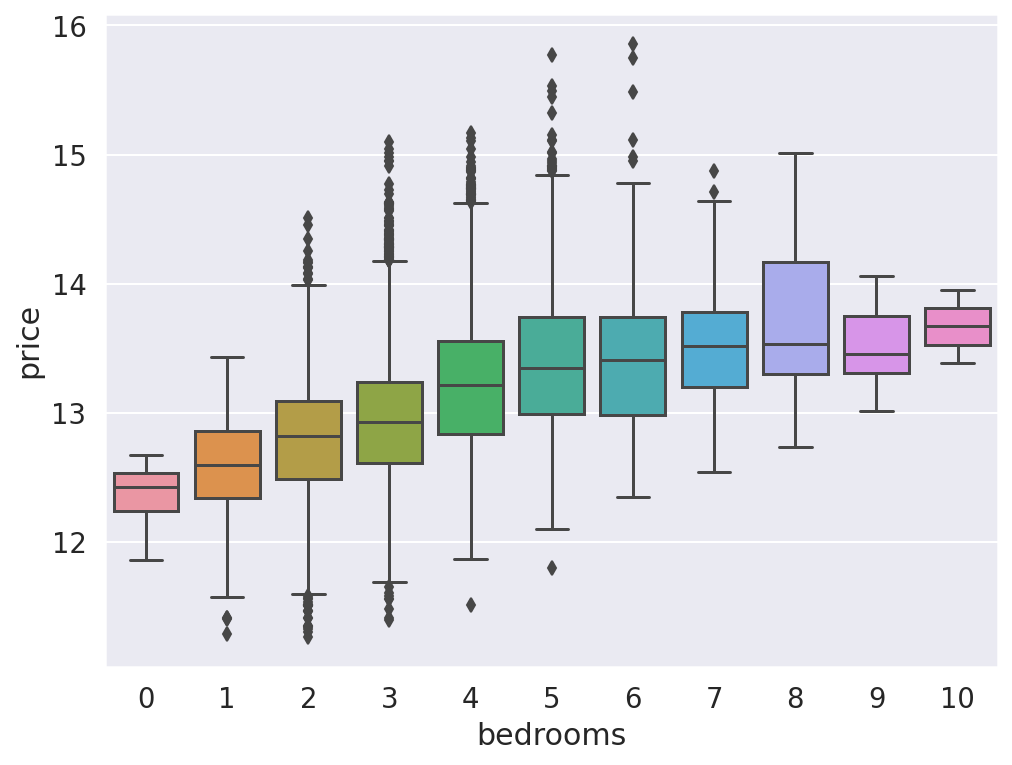

In [116]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

### 3.2 정규화

In [117]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

### 3.3 변수 수정

In [118]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

## 4. 변수 생성

In [119]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [120]:
for df in [df_train,df_test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [121]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [124]:
for df in [df_train,df_test]:
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] + df['sqft_lot']
    
    # 15년도가 아닌 주변 15개 가구 평균값
    df['sqft_total_size15'] = df['sqft_living15'] + df['sqft_lot15']
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [125]:
df_train['per_price15'] = df_train['price']/df_train['sqft_total_size15']
zipcode_price = df_train.groupby(['zipcode'])['per_price15'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size15']
    df['zipcode_var'] = df['var'] * df['sqft_total_size15']
    del df['mean']; del df['var']

In [126]:

for data in [df_train,df_test]:
    data['zipcode'] = data['zipcode'].astype(str)
    # 45, 5, 35, 4
    data['zipcode-3'] = 'z_' + data['zipcode'].str[2:3]
    data['zipcode-4'] = 'z_' + data['zipcode'].str[3:4]
    data['zipcode-5'] = 'z_' + data['zipcode'].str[4:5]
    data['zipcode-34'] = 'z_' + data['zipcode'].str[2:4]
    data['zipcode-45'] = 'z_' + data['zipcode'].str[3:5]
    data['zipcode-35'] = 'z_' + data['zipcode'].str[2:3] + data['zipcode'].str[4:5]
    
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# zipcode LabelEncoding
for df in [df_train,df_test]:
    le = LabelEncoder()
    df['zipcode'] = le.fit_transform(df['zipcode'])
    df['zipcode-3'] = le.fit_transform(df['zipcode-3'])
    df['zipcode-4'] = le.fit_transform(df['zipcode-4'])
    df['zipcode-5'] = le.fit_transform(df['zipcode-5'])
    df['zipcode-34'] = le.fit_transform(df['zipcode-34'])
    df['zipcode-45'] = le.fit_transform(df['zipcode-45'])
    df['zipcode-35'] = le.fit_transform(df['zipcode-35'])

In [127]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var,sqft_total_size15,per_price15,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,66,47.5112,-122.257,1340,5650,4.00,0.818803,15.713705,1.0,0.237168,0,1.740145,9.674354,0.000756,6990,0.001761,1,7,8,16,54,16
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,16,47.7379,-122.233,2720,8062,3.00,0.721756,15.858129,1.0,0.337385,0,1.820290,13.614999,0.005947,10782,0.001122,0,2,8,2,24,8
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,37,47.6168,-122.045,1800,7503,5.00,0.825489,16.424415,1.0,0.239904,0,1.769478,9.989896,0.001229,9303,0.001413,0,7,4,7,51,4
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,2,47.3097,-122.327,2238,6819,5.25,0.843688,16.275366,1.0,0.328201,0,1.672824,10.942381,0.001553,9057,0.001376,0,0,3,0,2,3
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,68,47.4095,-122.315,1650,9711,4.50,0.758837,16.148085,1.0,0.169910,0,1.806238,14.470305,0.002011,11361,0.001108,1,9,8,18,57,16


In [128]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

for df in [df_train,df_test]:
    coord = df[['lat','long']]
    pca = PCA(n_components=2)
    pca.fit(coord)

    coord_pca = pca.transform(coord)

    df['coord_pca1'] = coord_pca[:, 0]
    df['coord_pca2'] = coord_pca[:, 1]

In [129]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']

In [130]:
for df in [df_train,df_test]:
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] + df['sqft_lot']
    
    # 15년도가 아닌 주변 15개 가구 평균값
    df['sqft_total_size15'] = df['sqft_living15'] + df['sqft_lot15']
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [131]:
df_train['zipcode_mean'].describe()
df_train['price'].describe()

count    15029.000000
mean        13.048202
std          0.527362
min         11.264477
25%         12.682310
50%         13.017005
75%         13.377007
max         15.856731
Name: price, dtype: float64

In [132]:
np.expm1(df_train.loc[df_train['id'] == 6469]['price'])

6465    6885000.0
Name: price, dtype: float64

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,per_price,zipcode_mean,zipcode_var,sqft_total_size15,per_price15,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,coord_pca1,coord_pca2


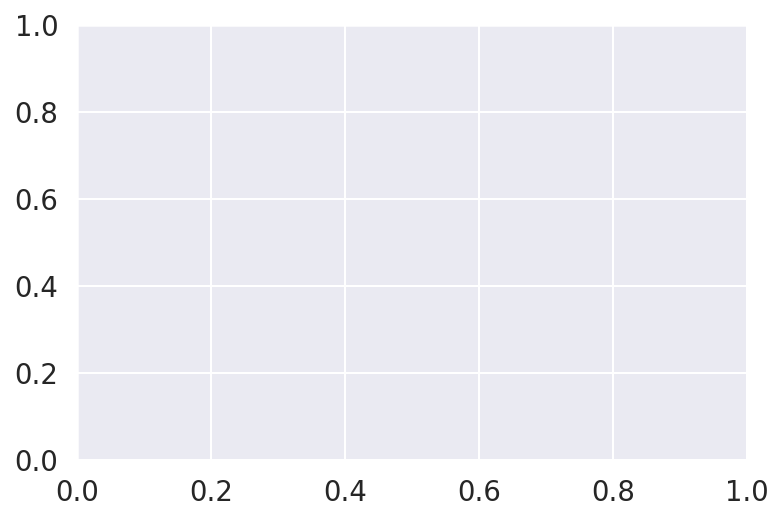

In [133]:
# 위에서 만든 per_price(평당 가격), zipcdoe_mean(zipcode 그룹별 평균 가격) 기준으로
# 부자 가구 상위 4개 추출
df_temp = df_train.loc[(df_train['per_price15'] > 0.8)&(df_train['per_price'] > 0.59)&(df_train['zipcode_mean'] > 15.3)]
#df_temp = df_train.loc[(df_train['price'] > 15.5)]
sns.scatterplot(x='long', y='lat', hue='id', hue_order=np.sort(df_temp['price'].unique()), data=df_temp)
df_temp

## 5. 모델링

In [134]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15029 entries, 0 to 15028
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15029 non-null  int64  
 1   date               15029 non-null  int64  
 2   price              15029 non-null  float64
 3   bedrooms           15029 non-null  int64  
 4   bathrooms          15029 non-null  float64
 5   sqft_living        15029 non-null  float64
 6   sqft_lot           15029 non-null  float64
 7   floors             15029 non-null  float64
 8   waterfront         15029 non-null  int64  
 9   view               15029 non-null  int64  
 10  condition          15029 non-null  int64  
 11  grade              15029 non-null  int64  
 12  sqft_above         15029 non-null  float64
 13  sqft_basement      15029 non-null  float64
 14  yr_built           15029 non-null  int64  
 15  yr_renovated       15029 non-null  float64
 16  zipcode            150

###단순 선형회귀

In [135]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

train_columns = [c for c in df_train.columns if c not in ['id','price','per_price', 'per_price15']]

model = sm.OLS(df_train['price'].values, df_train[train_columns])
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1955.
Date:                Mon, 09 Aug 2021   Prob (F-statistic):               0.00
Time:                        16:25:33   Log-Likelihood:                 251.40
No. Observations:               15029   AIC:                            -440.8
Df Residuals:                   14998   BIC:                            -204.7
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
date               5.341e-06   4.41e-0

In [136]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()

vif["Features"] = df_train.columns
vif["VIF Values"] = [variance_inflation_factor(
    df_train.values, i) for i in range(df_train.shape[1])]

vif.sort_values(by='VIF Values',ascending=False)

,Features,VIF Values
20,sqft_lot15,inf
13,sqft_basement,inf
38,coord_pca1,inf
37,zipcode-35,inf
34,zipcode-5,inf
32,zipcode-3,inf
30,sqft_total_size15,inf
23,sqft_total_size,inf
21,total_rooms,inf
19,sqft_living15,inf


### Light GBM

In [137]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = df_train['price']

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.137492	valid_1's rmse: 0.155566
[1000]	training's rmse: 0.118562	valid_1's rmse: 0.153037
[1500]	training's rmse: 0.105598	valid_1's rmse: 0.152568
Early stopping, best iteration is:
[1460]	training's rmse: 0.10653	valid_1's rmse: 0.152562
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.137146	valid_1's rmse: 0.158155
[1000]	training's rmse: 0.118643	valid_1's rmse: 0.154822
[1500]	training's rmse: 0.105867	valid_1's rmse: 0.153898
Early stopping, best iteration is:
[1467]	training's rmse: 0.106648	valid_1's rmse: 0.153873
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.137302	valid_1's rmse: 0.160907
[1000]	training's rmse: 0.11855	valid_1's rmse: 0.157044
[1500]	training's rmse: 0.105905	valid_1's rmse: 0.155927
[2000]	training's rmse: 0.0958497	valid_1's rmse: 0.155617
[2500]	training's rmse: 0.087339	valid_1's rmse: 

In [138]:
cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

116891.17137148711


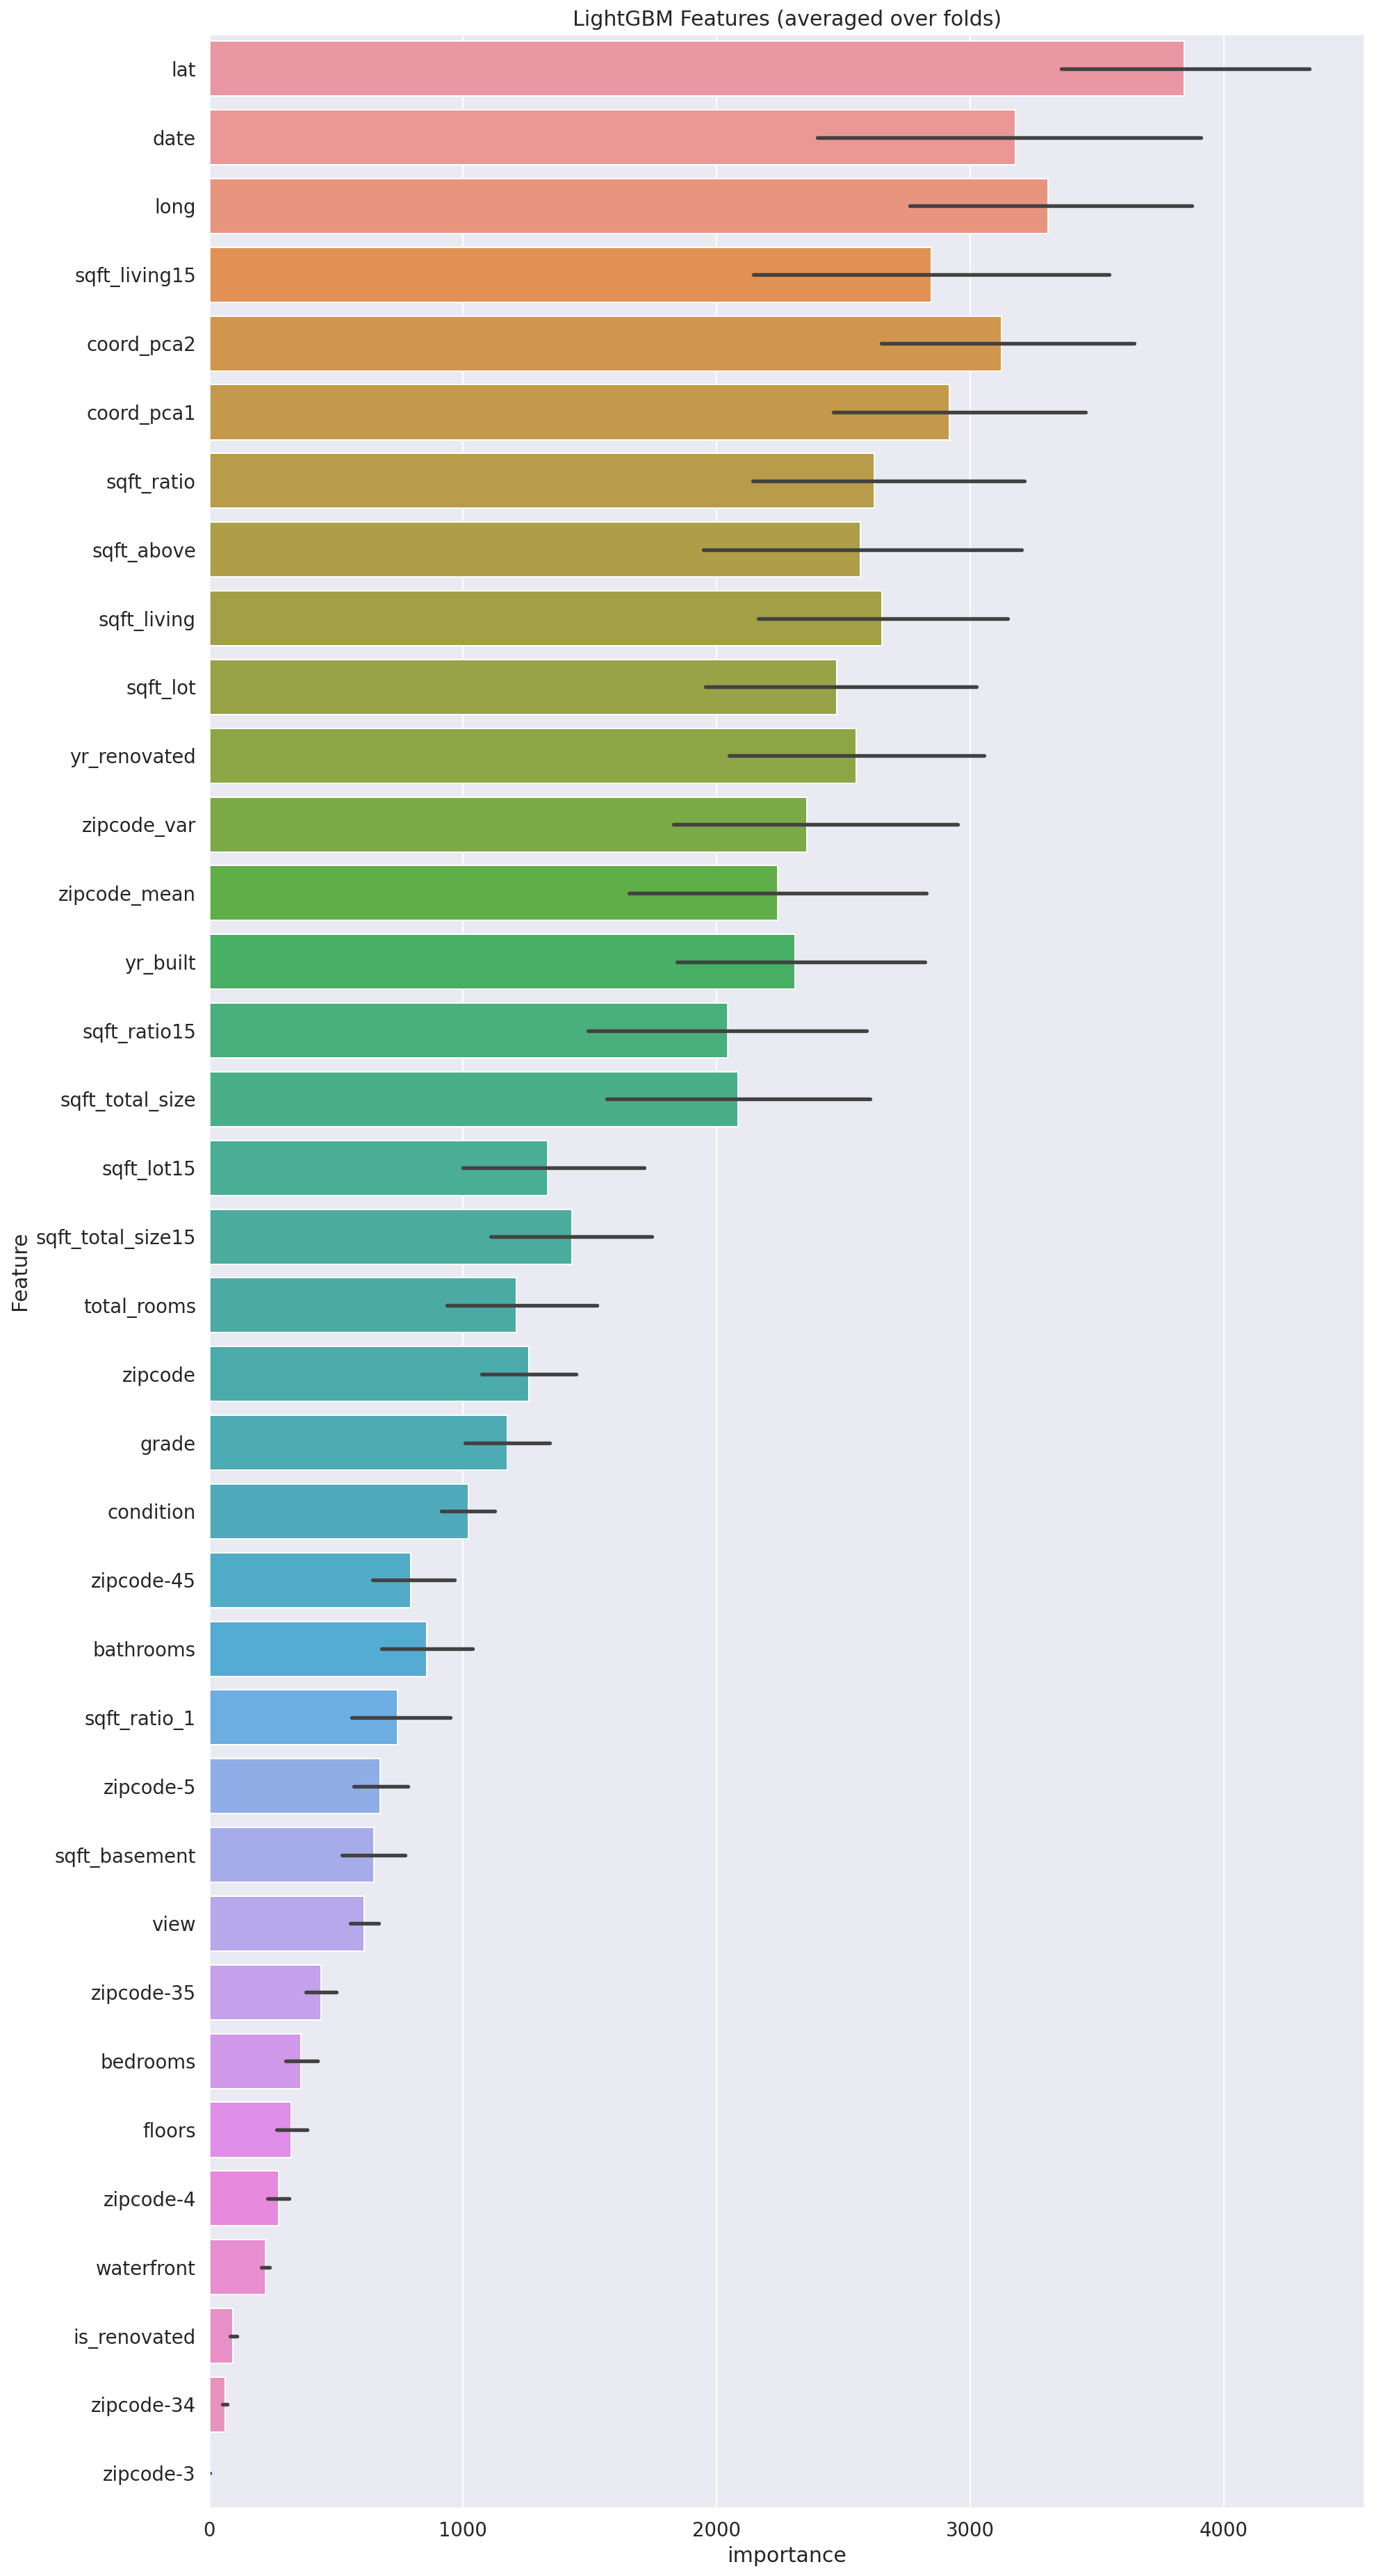

In [139]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

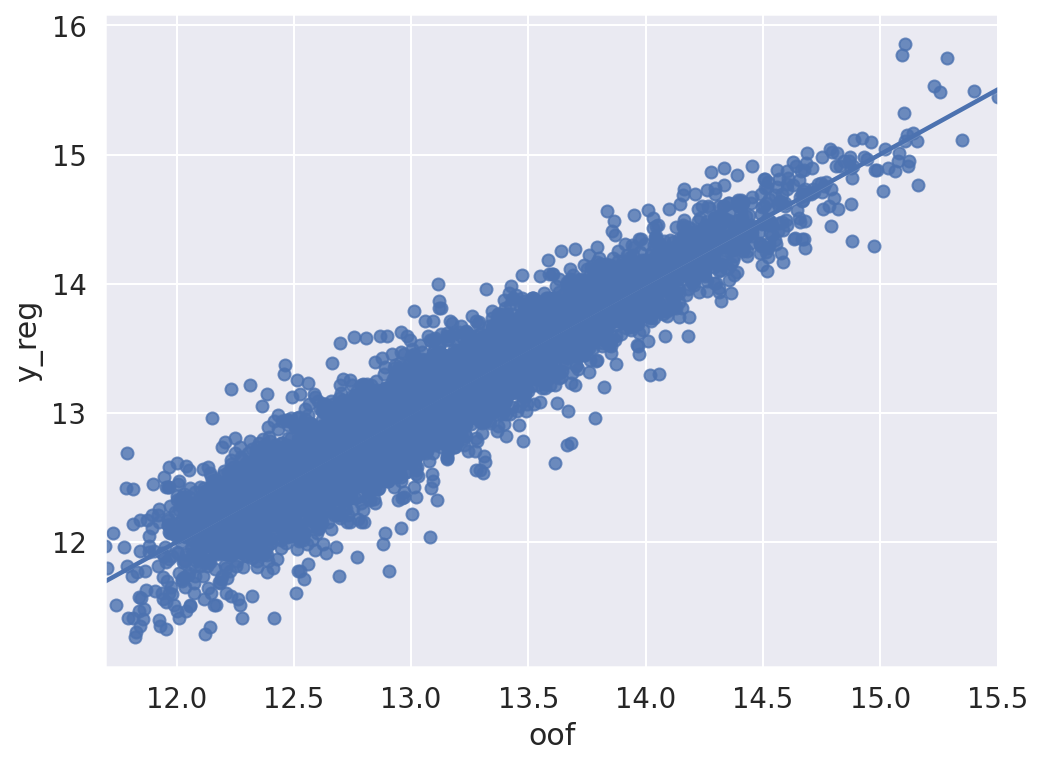

In [140]:
df_oof = pd.DataFrame(oof)
df_y_reg = pd.DataFrame(y_reg)

data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='oof', y="y_reg", data=data)

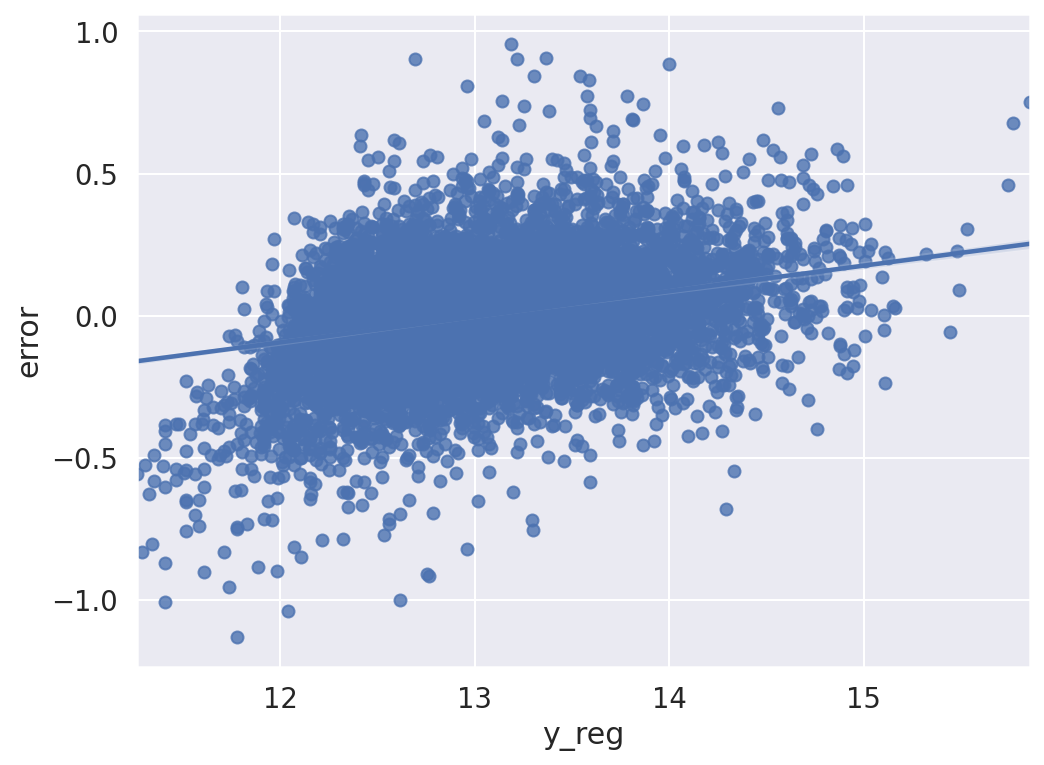

In [141]:
data = pd.concat([df_oof, df_y_reg], axis=1)
data.columns = ['oof','y_reg']
data['error'] = data['y_reg'] - data['oof']
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='y_reg', y="error", data=data)

앙상블

In [142]:
lgb1_oof = pd.DataFrame()
lgb1_oof['id'] = df_train.id
lgb1_oof['price'] = oof

lgb1_sub = pd.DataFrame()
lgb1_sub['id'] = df_test.id
lgb1_sub['price'] = predictions

cv1 = np.sqrt(mean_squared_error(np.expm1(oof), np.expm1(y_reg)))
print(cv1)

116891.17137148711


In [143]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}

y_reg = np.expm1(df_train['price'])

#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)

Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 133330	valid_1's rmse: 133471
[1000]	training's rmse: 107906	valid_1's rmse: 123738
Early stopping, best iteration is:
[1281]	training's rmse: 101548	valid_1's rmse: 123438
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 133225	valid_1's rmse: 133305
[1000]	training's rmse: 107812	valid_1's rmse: 115455
[1500]	training's rmse: 97804.7	valid_1's rmse: 112487
[2000]	training's rmse: 90419.2	valid_1's rmse: 111952
Early stopping, best iteration is:
[1956]	training's rmse: 90979.3	valid_1's rmse: 111907
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 132386	valid_1's rmse: 142123
[1000]	training's rmse: 108087	valid_1's rmse: 123765
[1500]	training's rmse: 98207.4	valid_1's rmse: 119647
[2000]	training's rmse: 91418.2	valid_1's rmse: 117788
[2500]	training's rmse: 86018.2	valid_1's rmse: 116674
[3000]	training's rmse: 81389.7	vali

In [144]:
lgb2_oof = pd.DataFrame()
lgb2_oof['id'] = df_train.id
lgb2_oof['price'] = oof

lgb2_sub = pd.DataFrame()
lgb2_sub['id'] = df_test.id
lgb2_sub['price'] = predictions

cv2 = np.sqrt(mean_squared_error(oof, y_reg))
print(cv2)

124885.66934951978


In [145]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

log_y_reg = np.log1p(y_reg)
print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], log_y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=5000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb1_sub = df_test[['id']]
xgb1_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[0]	train-rmse:12.4339	test-rmse:12.4339
[500]	train-rmse:0.174159	test-rmse:0.192536
[1000]	train-rmse:0.123963	test-rmse:0.161451
[1500]	train-rmse:0.108288	test-rmse:0.158792
[2000]	train-rmse:0.096839	test-rmse:0.157832
[2500]	train-rmse:0.0877397	test-rmse:0.157379
[3000]	train-rmse:0.080285	test-rmse:0.157138
best num_boost_rounds =  3089


In [146]:
# code : https://www.kaggle.com/karell/kakr-2nd-house-price-xgb-starter-109145
import xgboost as xgb

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

print('Transform DMatrix...')
dtrain = xgb.DMatrix(df_train[train_columns], y_reg)
dtest = xgb.DMatrix(df_test[train_columns])

print('Start Cross Validation...')

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=20000, early_stopping_rounds=50,verbose_eval=500, show_stdv=False)
print('best num_boost_rounds = ', len(cv_output))
rounds = len(cv_output)

model = xgb.train(xgb_params, dtrain, num_boost_round = rounds)
preds = model.predict(dtest)

xgb2_sub = df_test[['id']]
xgb2_sub['price'] = preds

Transform DMatrix...
Start Cross Validation...
[0]	train-rmse:650065	test-rmse:650127
[500]	train-rmse:81143.2	test-rmse:130301
[1000]	train-rmse:64585.9	test-rmse:125004
[1500]	train-rmse:55164.3	test-rmse:123482
[2000]	train-rmse:48877.6	test-rmse:122817
[2500]	train-rmse:43967.7	test-rmse:122477
[3000]	train-rmse:40119.9	test-rmse:122293
[3500]	train-rmse:36921.5	test-rmse:122136
best num_boost_rounds =  3854


In [147]:
lgb_oof = pd.merge(lgb1_oof,lgb2_oof,how='left',on='id')
lgb_train = df_train[['id','price']]
lgb_oof = pd.merge(lgb_oof,lgb_train,how='left',on='id')
lgb_oof.columns = ['id','price1','price2','price']

lgb_ensemble = (0.9*np.expm1(lgb_oof['price1']) + 0.1*lgb_oof['price2']).values
cv = np.sqrt(mean_squared_error(lgb_ensemble, np.expm1(lgb_oof['price']).values))
print(cv)

116686.45555301376


In [148]:
lgb_sub = pd.merge(lgb1_sub,lgb2_sub,how='left',on='id')
lgb_sub.columns = ['id','price1','price2']
lgb_sub['price'] = (0.9*np.expm1(lgb_sub['price1']) + 0.1*lgb_sub['price2'])
lgb_sub = lgb_sub[['id','price']]

In [149]:
xgb_sub = pd.merge(xgb1_sub,xgb2_sub,how='left',on='id')
xgb_sub.columns = ['id','price1','price2']
xgb_sub['price'] = (0.9*np.expm1(xgb_sub['price1']) + 0.1*xgb_sub['price2'])
xgb_sub = xgb_sub[['id','price']]

In [150]:
ensemble_sub = pd.merge(lgb_sub,xgb_sub,how='left',on='id')
ensemble_sub.columns = ['id','price1','price2']
ensemble_sub['price'] = 0.9*ensemble_sub['price1'] + 0.1*ensemble_sub['price2']
ensemble_sub = ensemble_sub[['id','price']]
ensemble_sub.to_csv("submission.csv",index=False)

----